# Data Exploration 2 - Trader Characteristics

This notebook will examine the seller trends for 



This notebook is structured:
    1. Parameter Sets
    2. Plotting days to sale
    3. Calculating and plotting Z-scores
        
# 1. Parameter Sets

As shown in the marketplace.py simulation, there are a range of initial parameters we can choose which characterise the market behaviour. Because there are so many possible combinations, which cause drastically different effects, we will proceed by defining a set of seven distinct parameter sets of increasing complexity. These are then treated seperately at the Prediction stage (Part 3 of the project). 

|   Params \ Set| 1           |  2  | 3 | 4 | 5 | 6 | 7 |
| ------------- |:-------------:| -----:|
| Rate          | Constant | Sine | GBM | Constant | Sine | GBM | GBM |
| EUR $N$           | 100   | 100   | 100   | 120   | 120   | 120   | 120 |
| $N$ selection | Fixed | Fixed | Fixed | Fixed | Fixed | Fixed | Gauss (SD = 20) |
| EUR $\mu$  | 9     |  9    |   9   | 9     | 9     | 9     | 9.5 |
| EUR $\sigma$|1     |   1   |   1   |  1    |  1    |  1    | 0.5 |

Constants:

| Param                | Value |  
| ------------- |:-------------:| 
| Days cutoff          | 8  | 
| Iterations           | 300 | 
| USD $\mu$           | 9   | 
| USD $\sigma$      | 1   | 
| $N$ USD           | 100   | 

A full description of these was given in the documentation of marketplace.py. A total of 5 market simulations were performed for each parameter set for use in the Prediction part of the project.

# 2. Days to sale

The default dataset below is taken from parameter set 7, run #4. This is the most complex marketplace simulation and thus has the most interesting behaviour. Below we'll plot the length of time taken until a sale is made for each currency, and also count how many sellers were unable to find a sale at all.

array([<matplotlib.axes.AxesSubplot object at 0x7f47f6836350>,
       <matplotlib.axes.AxesSubplot object at 0x7f47f626a350>], dtype=object)

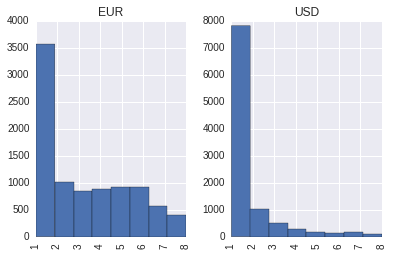

In [17]:
import pandas as pd
import matplotlib.pylab as plt
from ast import literal_eval
import seaborn as sns
from scipy import stats
%matplotlib inline
#fig, axes = plt.subplots(figsize=(6, 6))

## Choose a dataset and a run number
dataset = str(7) # Choose a parameter set 1-7
run = str(4)     # Select a run

sold = pd.read_csv('./data/'+dataset+'_set_run_'+run+'_sold.csv');
unsold = pd.read_csv('./data/'+dataset+'_set_run_'+run+'_unsold.csv');
rates = pd.read_csv('./data/'+dataset+'_set_run_'+run+'_rates.csv');

rate_dic = rates.to_dict()['USD to EUR rate']

### Trim points under cutoff days while market was stabilising
sold = sold[sold['Day Advertised'] >  60]
sold = sold[sold['Day Advertised'] < 180]
unsold = unsold[unsold['Day Advertised'] >  60]
unsold = unsold[unsold['Day Advertised'] < 180]
### Day Tracker list was saved as string. Convert back to a list
sold['Day Tracker'] = sold['Day Tracker'].apply(lambda x: x.split(','));
### Get length of day tracker, save as new column - This is days spent in the market
sold['Lens'] = sold['Day Tracker'].apply(lambda x : len(x));

### Keep only short lengths
sold = sold[sold['Lens']< 9]
# Plot histograms of length to sale, seperate by currency
sold['Lens'].hist(bins = 8,by=sold['Currency'])

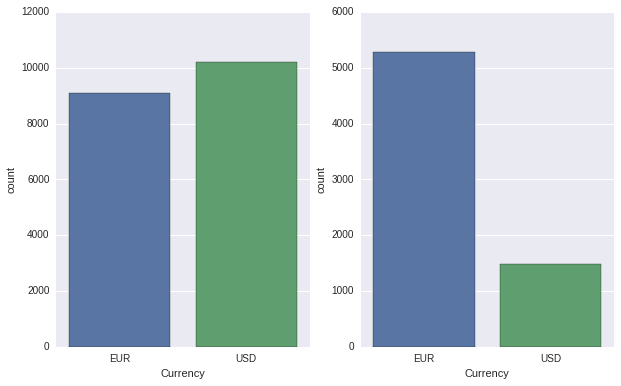

In [18]:
# Count successful and unsuccessful sellers
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 6))
sns.countplot(x="Currency", data=sold, ax=axes[0])
sns.countplot(x="Currency", data=unsold, ax=axes[1])

Clearly, the imbalance in seller numbers and the distribution of their amounts between markets has had a large impact on the trades. Recall that the EUR market had a mean of 120 vs 100 sellers in the USD market, moreover the exact number on each market iteration was chosen from a Gaussian distribution about these means with a standard deviation of 20. The amounts of the EUR buyers and sellers was much larger due to the change of the parameters defining the Log-norm distribution from which these are taken. 

In the first histogram, almost twice as many USD sellers than EUR sellers sold on the first day their sale was advertised (8000 vs 3600 respectively). Over the week, before the 8 day cutoff when a trade is cancelled, there were approximately 9000 vs 10,000 sales in the EUR and USD markets respectively, with a proportionally large number of sales occuring in the EUR market on Day 2 onwards. 

In the second histogram, it is shown that approximately 4 times as many EUR sellers did not get matched with a buyer compared to those in the USD market. This is a consequence of their amounts generally being much larger AND the fact that there are more in number - on average there are 5:4 EUR sellers to prospective buyers.


# 3. Calculating and plotting z-scores

Because of the rules of the market, sellers who choose a rate that is worse for themselves (but better for buyers) will sell first. It is insightful for us to look at how this determines the length of time it takes a sale to complete - we can do this by first calculating the Z-score of all the sellers and then plotting this with respect to the rate on the day they advertised. 

This will now be done for the USD and EUR markets seperately. Negative Z-scores correspond to rates that are below the mean interbank rate on the day they were placed and so should be more successful in selling.

array([[<matplotlib.axes.AxesSubplot object at 0x7f47f0a0ad90>,
        <matplotlib.axes.AxesSubplot object at 0x7f47f07ff710>]], dtype=object)

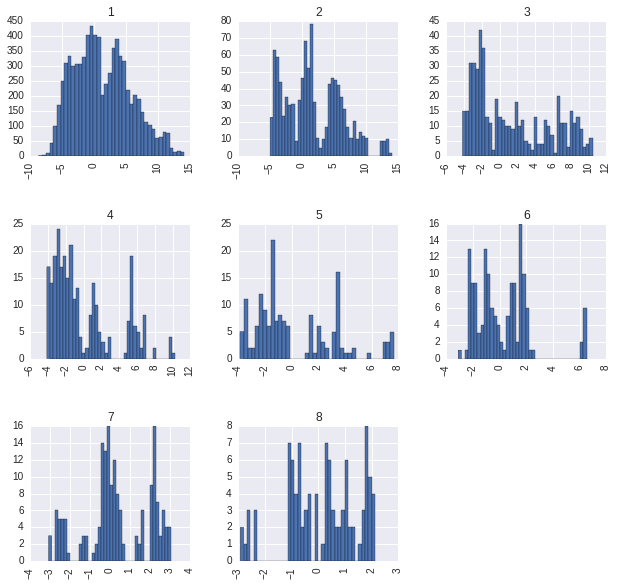

In [23]:
# Unfortunately this kicks up a warning, ignore it for now as the plot is fine
import warnings
warnings.filterwarnings('ignore')
### Calculate Z-scores for USD sellers
usd = sold[sold['Currency'] ==  'USD']
usd['zscores'] = usd.apply(lambda row: (rate_dic[row['Day Advertised']]),axis=1)
usd['zscores'] = usd.apply(lambda row: (\
    (row['Rate Offered']-rate_dic[row['Day Advertised']] )/((rate_dic[row['Day Advertised']])/100.0)),axis=1)
usd['zscores'].hist(bins = 40,align='mid',by=usd['Lens'],figsize=(10,10))

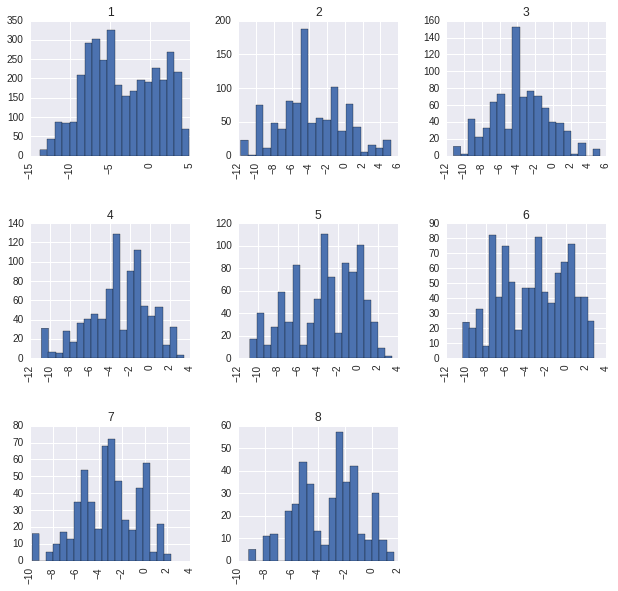

In [20]:
# Calculate and plot Z-scores for EUR sellers
eur = sold[sold['Currency'] ==  'EUR']
eur['zscores'] = eur.apply(lambda row: (\
    (row['Rate Offered']-(1.0/rate_dic[row['Day Advertised']]) )/((1.0/rate_dic[row['Day Advertised']])/100.0)),axis=1)
eur['zscores'].hist(bins = 20,align='mid',by=eur['Lens'],figsize=(10,10))
plt.show()

With both currencies we can see the mean slowly moving to the right as the number of days increases - as the market rate changes against the favourability of their home currency these orders become more attractive to buyers, increasing the likelehood they are sold.

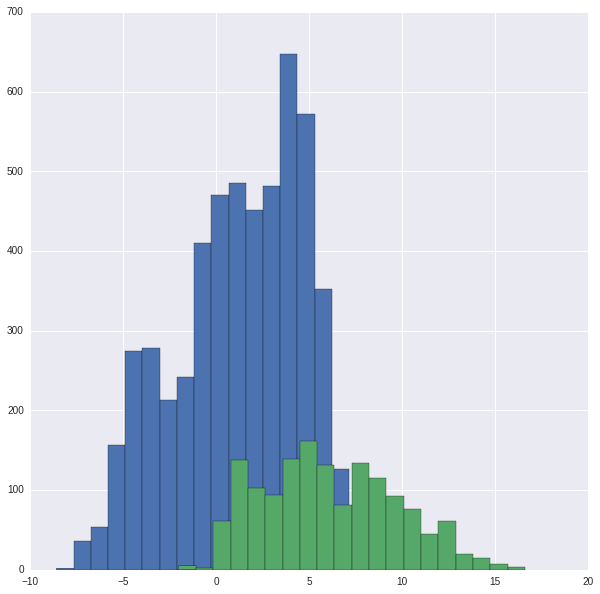

In [24]:
# Take a look at sellers who didn't sell

## EUR
eur_unsold = unsold[unsold['Currency'] ==  'EUR']
eur_unsold['zscores'] = eur_unsold.apply(lambda row: (\
    (row['Rate Offered']-(1.0/rate_dic[row['Day Advertised']]) )/((1.0/rate_dic[row['Day Advertised']])/100.0)),axis=1)
eur_unsold['zscores'].hist(bins=20,label='EUR')

## USD
usd_unsold = unsold[unsold['Currency'] ==  'USD']
usd_unsold['zscores'] = usd_unsold.apply(lambda row: (\
    (row['Rate Offered']-(rate_dic[row['Day Advertised']]) )/((rate_dic[row['Day Advertised']])/100.0)),axis=1)
usd_unsold['zscores'].hist(bins=20,figsize=(10,10),label='USD')

Because there are more sellers in the EUR market than buyers in the USD market, who also are demanding much more money than the buyers have available, there are still sellers who had fairly competetive rates who did not complete their sale.

# Summary

Now we have a general understanding of the data, and the roles of the various inputs, we will proceed with trying to predict the success of sellers in each parameter set. This takes place in the prediction/ directory, the first notebook that should be read is deal_or_no_deal.ipynb which seeks to classify whether a seller will successfully sell or not. This is followed by time_to_sale_prediction.ipynb which uses regression to predict how long it takes a successful seller to complete their sale.